In [28]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from tqdm import tqdm
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
import warnings

warnings.filterwarnings("ignore",message='ERROR:lightkurve.search')
# warnings.filterwarnings('ignore', message=f'No data found for target')
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import exoplanet as xo

import arviz as az

Populating the interactive namespace from numpy and matplotlib
4.3.1


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'axes', 'trace', 'e']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [1038]:
calibverr = astab.Table.read('dr17_joker/allVisit-dr17-synspec-calib-verr.fits', format='fits', hdu=1)
print(calibverr.info)

<Table length=2318773>
   name     dtype 
---------- -------
  VISIT_ID bytes64
CALIB_VERR float64



##### load in apogee visit data for TIC 99254945 

In [1042]:
sysapodat = astab.Table.read('dr17_joker/tic_beatdrop_system_apogee_dat.fits',format='fits',hdu=1)
print(len(sysapodat))
sysapodat = astab.join(sysapodat, calibverr, keys=('VISIT_ID','VISIT_ID'))
print(len(sysapodat))

6
6


##### load in apogee visit data for TIC 20215452 (has more visits in RV for easier fitting)

In [961]:
sysapodat2 = astab.Table.read("dr17_joker/tic20215452_apogee_visit_data.fits", hdu=1, format='fits')

<ErrorbarContainer object of 3 artists>

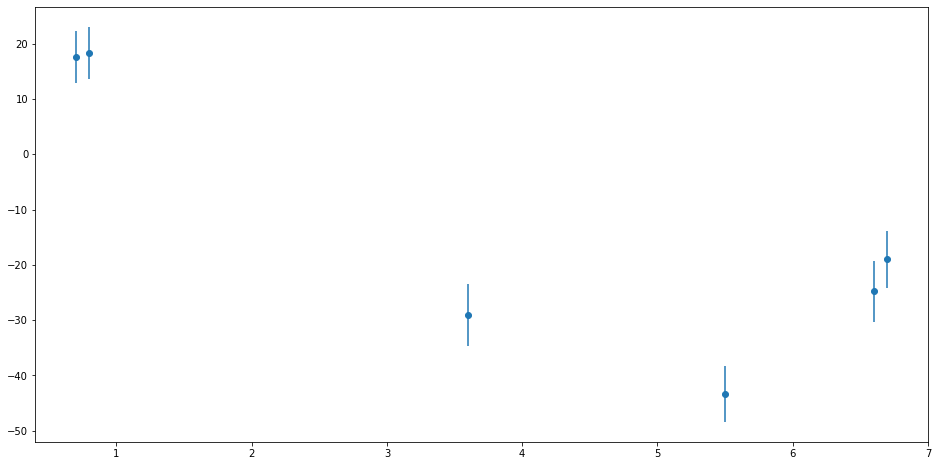

In [1046]:
fig,ax = plt.subplots()
ax.errorbar(sysapodat['MJD']%7.7, sysapodat['VHELIO'],yerr=sysapodat['CALIB_VERR']*100,fmt='o')

## straight up ctrl-c, ctrl-v from the exoplanet docs website: https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/#a-more-realistic-example-radial-velocity-exoplanets

In [1083]:
MAP_P,MAP_P_err = 7.7, _ 

rv = sysapodat['VHELIO']
rv_err = sysapodat['CALIB_VERR']
t = sysapodat['MJD'].astype("float")
t -= np.min(t)


rv_amp = 0.5 * (np.max(rv) - np.min(rv))
with pm.Model() as model:

    # Parameters
#     logK = pm.Uniform(
#         "logK",
#         lower=0,
#         upper=2*np.log(rv_amp),
#         testval=np.log(rv_amp),
#     )
    logK = pm.Normal(
        "logK",
        mu=np.log(rv_amp),
        sd=5,
        testval=np.log(rv_amp)
    )


    logP = pm.Normal(
        "logP",mu=np.log(7.7), sd=5, testval=np.log(MAP_P) 
     )
#     logP = pm.Uniform(
#             "logP", lower=0, upper=np.log(10), testval=np.log(MAP_P))
    
#     logP = pm.Lognormal(
#         "logP",
#         mu=4.8,
#         sd=2.3,
#         testval = np.log(MAP_P)
#     )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)
    
#     prephi = pmx.UnitUniform("prephi", testval=0.1)
#     phi = pm.Deterministic('phi', 2.*np.pi*prephi)
    
    
    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    hk = pmx.UnitDisk("hk", testval=np.array([0.01, 0.01]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    
    ## adding in some wiggle room (e.g. jitter) on the RV measurements 
    log_sigma_rv = pm.Normal(
        "log_sigma_rv", mu=np.log(np.median(rv_err)), sd=10.
    )
    
    err = tt.sqrt(rv_err ** 2 + tt.exp(2 * log_sigma_rv))
    # Condition on the observations
    pm.Normal("obs", mu=rvmodel, sd=err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )

In [1084]:
with model:
#     map_params = pmx.optimize(vars=[logK])
    map_params = pmx.optimize(start=map_params,vars=[logK,log_sigma_rv,rvtrend, rv0, hk, phi])
    map_params = pmx.optimize(start=map_params, vars=[logP])


    

optimizing logp for variables: [phi, hk, rv0, rvtrend, log_sigma_rv, logK]


message: Optimization terminated successfully.
logp: -30.539525627725816 -> -30.46377431636185


optimizing logp for variables: [logP]


message: Optimization terminated successfully.
logp: -30.46377431636185 -> -30.395046508330744


#### checking the map params optimization results

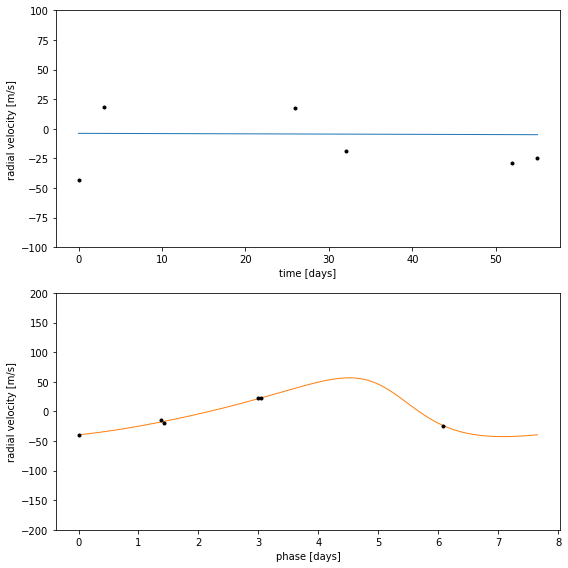

In [1085]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.plot(t, map_params["bkg"], color="C0", lw=1)
ax.set_ylim(-100, 100)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
ax.set_ylim(-200, 200)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

plt.tight_layout()

## RUN THE PYMC3 MODEL (DO NOT MELT THE RAM)

In [1086]:
with model:
    paramtrace = pmx.sample(
        draws=10000,
        tune=5000,
        start=map_params,
        chains=6,
        cores=6,
        target_accept=0.999,
        return_inferencedata=True,
    )

Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [log_sigma_rv, rvtrend, rv0, hk, phi, logP, logK]
INFO:pymc3:NUTS: [log_sigma_rv, rvtrend, rv0, hk, phi, logP, logK]


Sampling 6 chains for 5_000 tune and 10_000 draw iterations (30_000 + 60_000 draws total) took 784 seconds.
INFO:pymc3:Sampling 6 chains for 5_000 tune and 10_000 draw iterations (30_000 + 60_000 draws total) took 784 seconds.
The acceptance probability does not match the target. It is 0.9917434784601233, but should be close to 0.999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9926939330533634, but should be close to 0.999. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9878445173400993, but should be close to 0.999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9949014566370273, but should be close to 0.999. Try to increase the num

In [1087]:
az.summary(
    paramtrace,
    var_names=["logK", "logP", "phi", "e", "w", "rv0", "rvtrend"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logK,3.524,0.024,3.469,3.560,0.000,0.000,3301.0,4305.0,1.0
logP,2.046,0.001,2.044,2.048,0.000,0.000,3336.0,3241.0,1.0
phi,2.521,0.033,2.482,2.565,0.001,0.000,4215.0,3475.0,1.0
e,0.022,0.032,0.000,0.074,0.001,0.001,3851.0,3142.0,1.0
w,-0.146,1.302,-1.721,2.006,0.020,0.014,5005.0,12588.0,1.0
rv0,-15.567,0.643,-16.665,-14.182,0.012,0.008,3355.0,3317.0,1.0
rvtrend,2.593,6.172,-11.437,13.793,0.115,0.081,3229.0,4040.0,1.0


In [1088]:
from corner import corner

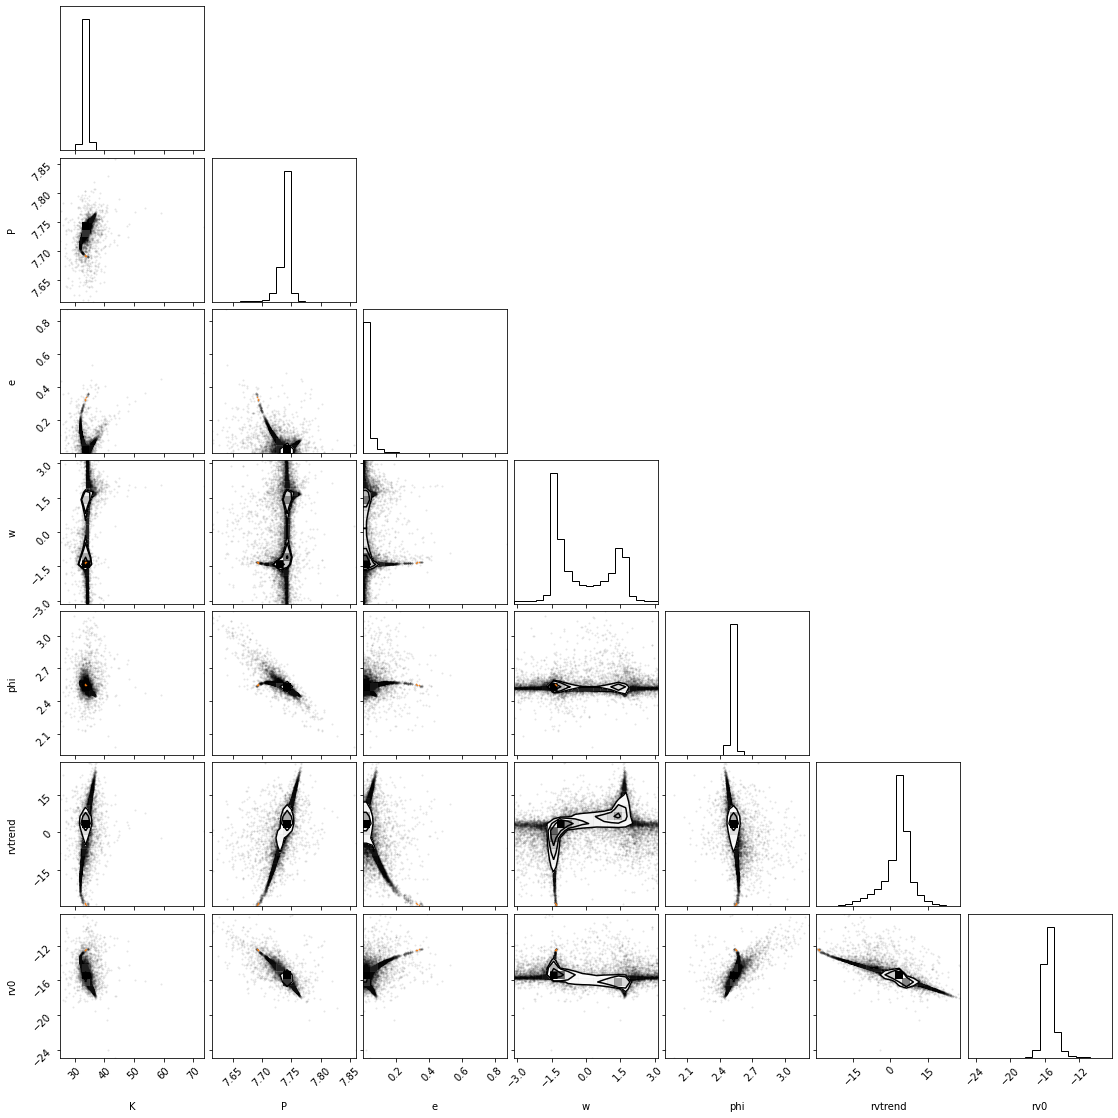

In [1089]:
_ = corner(paramtrace, var_names=['K','P','e','w','phi','rvtrend','rv0'], divergences=True, plot_contours=True)

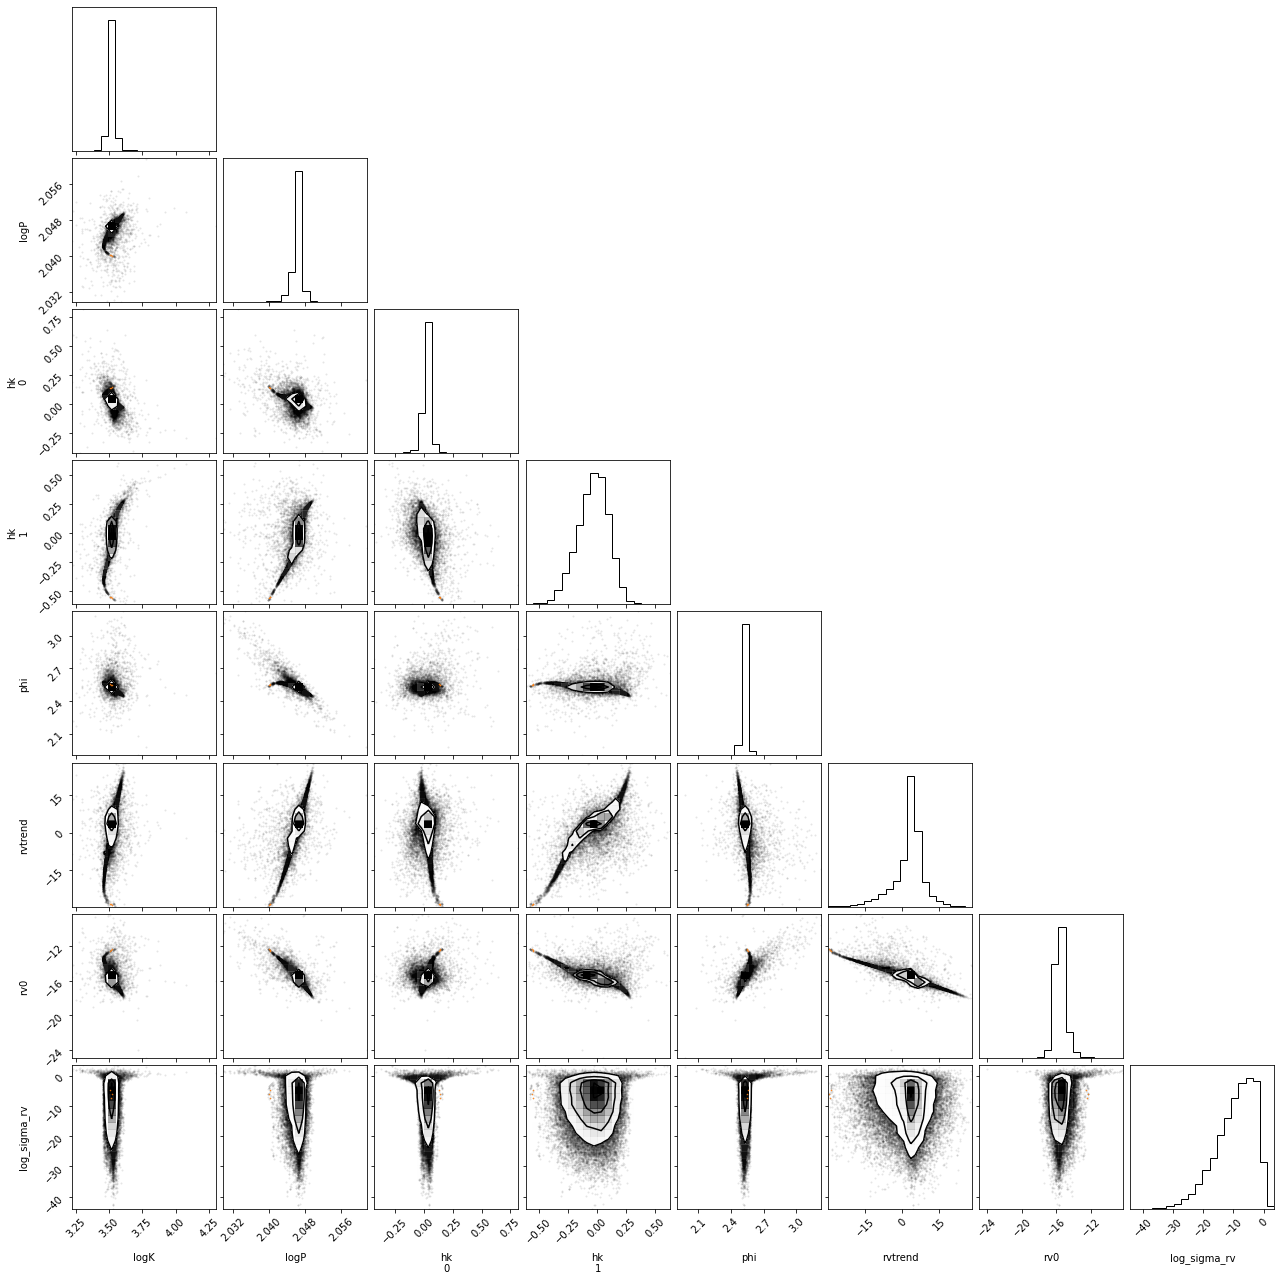

In [1090]:
_ = corner(paramtrace, var_names=['logK','logP','hk','phi','rvtrend','rv0','log_sigma_rv'], divergences=True, plot_contours=True)

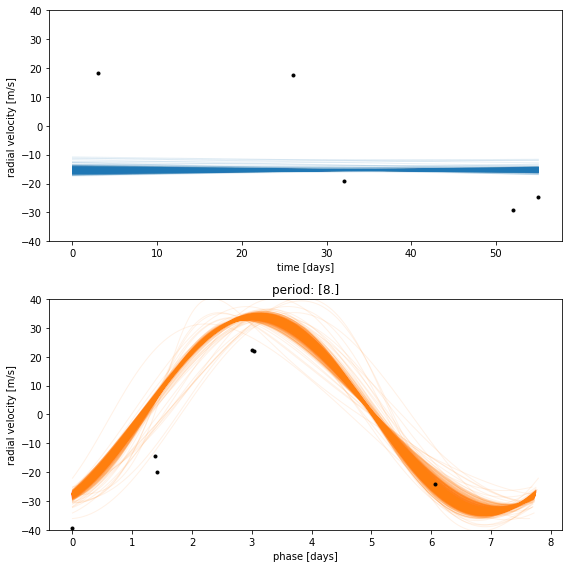

In [1093]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

bkg = paramtrace.posterior["bkg"].values
rvphase = paramtrace.posterior["rvphase"].values
mcmc_per = paramtrace.posterior['logP'].values

for ind in np.random.randint(np.prod(bkg.shape[:2]), size=1024):
    i = np.unravel_index(ind, bkg.shape[:2])
    axes[0].plot(t, bkg[i], color="C0", lw=1, alpha=0.1)
    axes[1].plot(phase * period, rvphase[i], color="C1", lw=1, alpha=0.1)
    
axes[0].set_ylim(-40, 40)
axes[1].set_ylim(-40, 40)
axes[1].set_title(f'period: {np.round(period.flatten())}')
plt.tight_layout()

array([[<AxesSubplot:title={'center':'logP'}>,
        <AxesSubplot:title={'center':'logP'}>],
       [<AxesSubplot:title={'center':'rv0'}>,
        <AxesSubplot:title={'center':'rv0'}>],
       [<AxesSubplot:title={'center':'rvtrend'}>,
        <AxesSubplot:title={'center':'rvtrend'}>],
       [<AxesSubplot:title={'center':'log_sigma_rv'}>,
        <AxesSubplot:title={'center':'log_sigma_rv'}>],
       [<AxesSubplot:title={'center':'logK'}>,
        <AxesSubplot:title={'center':'logK'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'hk'}>,
        <AxesSubplot:title={'center':'hk'}>],
       [<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'e'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>],
       [<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'P'}>],
       [<AxesSubplot:title={'center':'K'}>,
        <A

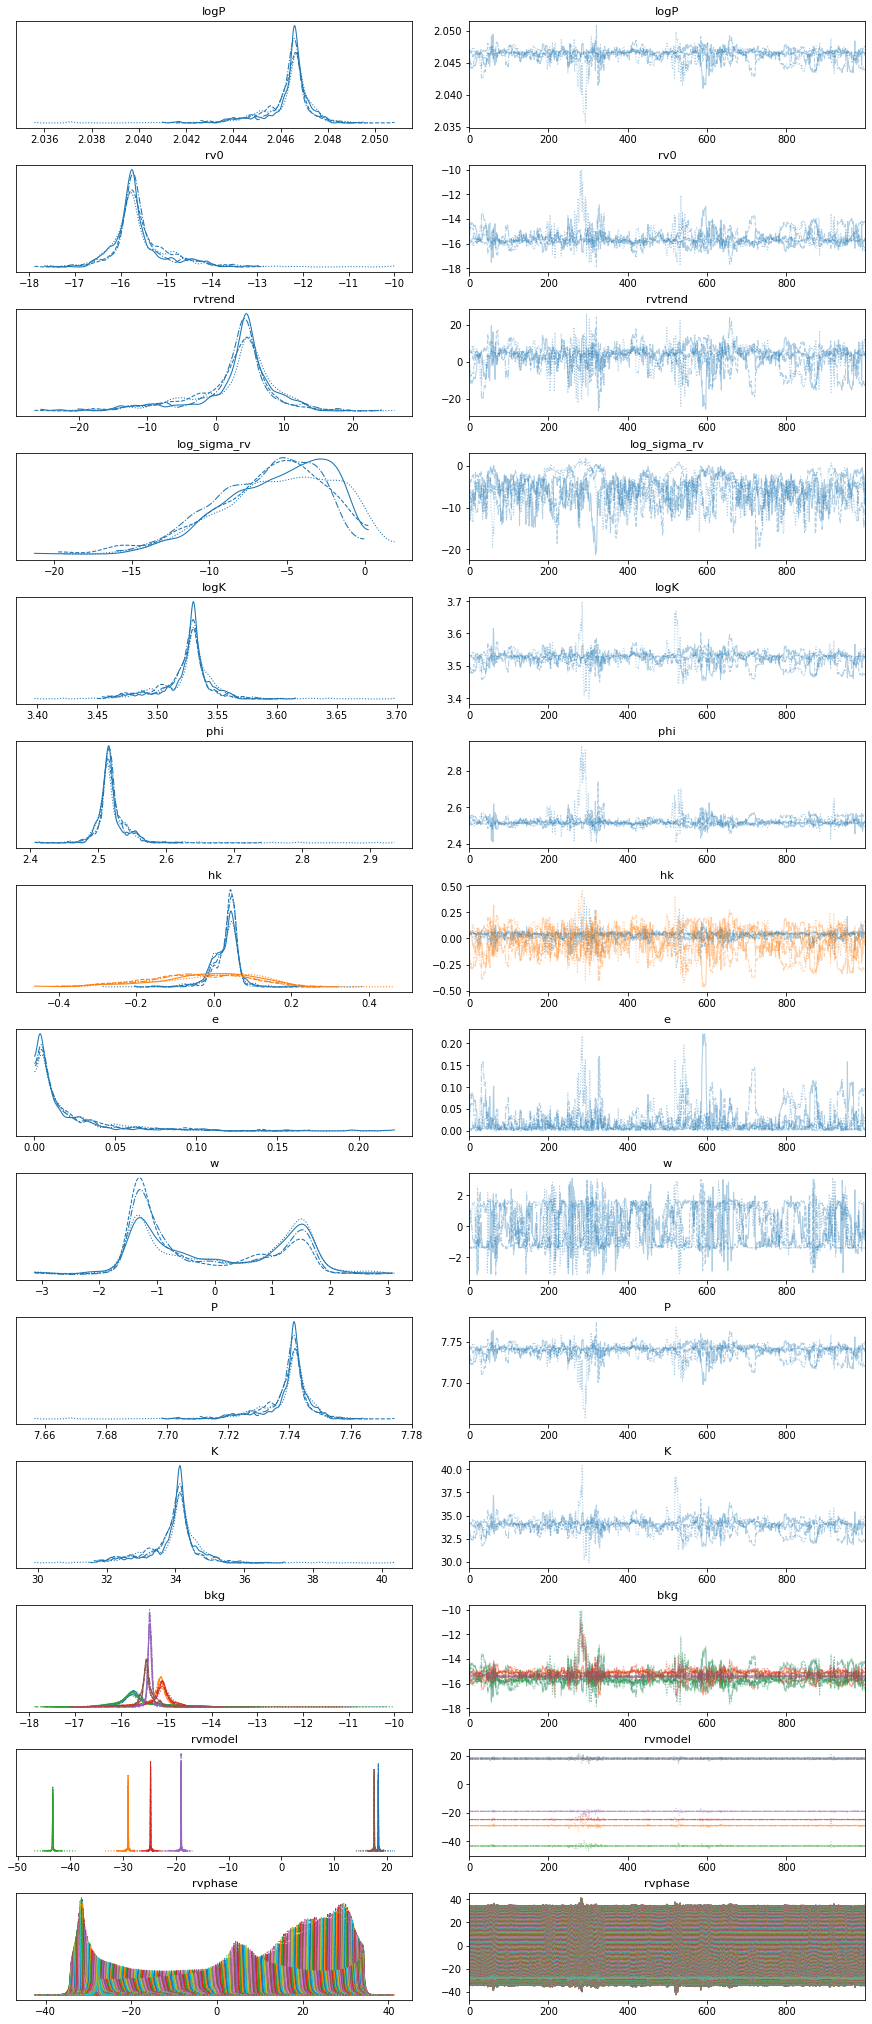

In [840]:
az.plot_trace(paramtrace)

# pymc3 RV model for TIC 20215452 (more RV measurements, might be SB2)

In [1094]:
sysapodat2 = astab.Table.read("dr17_joker/tic20215452_apogee_visit_data.fits", hdu=1, format='fits')
sysapodat2 = astab.join(sysapodat2, calibverr, keys=['VISIT_ID','VISIT_ID'])

<ErrorbarContainer object of 3 artists>

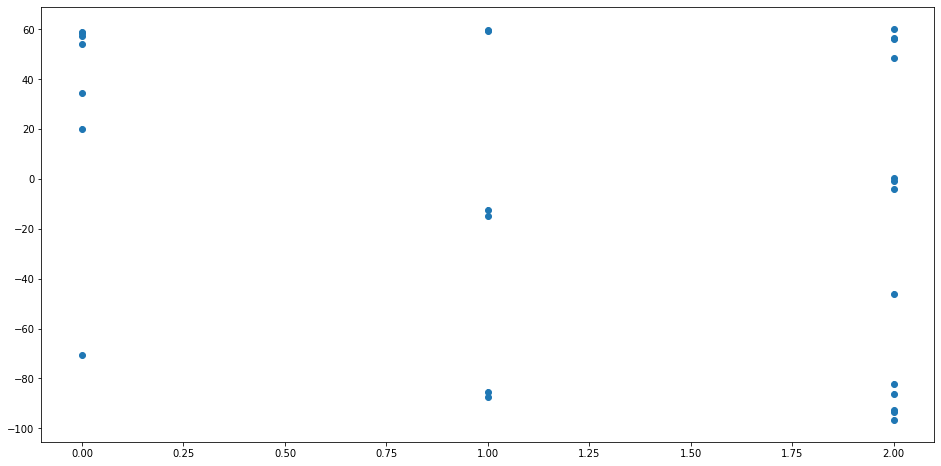

In [1101]:
fig,ax = plt.subplots()
ax.errorbar(sysapodat2['MJD']%3, sysapodat2['VHELIO'],yerr=sysapodat2['CALIB_VERR'],fmt='o')

In [985]:
MAP_P,MAP_P_err = 3.0, _ 

rv = sysapodat['VHELIO']
rv_err = sysapodat['VRELERR']
t = sysapodat['MJD'].astype("float")
t -= np.median(t)


rv_amp = 0.5 * (np.max(rv) - np.min(rv))
with pm.Model() as model:

    # Parameters
    logK = pm.Uniform(
        "logK",
        lower=0,
        upper=2*np.log(rv_amp),
        testval=np.log(rv_amp),
    )


    logP = pm.Normal(
        "logP",mu=np.log(10), sd=2, testval=np.log(MAP_P) 
     )
#     logP = pm.Uniform(
#             "logP", lower=0, upper=np.log(10), testval=np.log(MAP_P))
    
#     logP = pm.Lognormal(
#         "logP",
#         mu=4.8,
#         sd=2.3,
#         testval = np.log(MAP_P)
#     )
    phi = pm.Uniform("phi", lower=0, upper=2 * np.pi, testval=0.1)
    
#     prephi = pmx.UnitUniform("prephi", testval=0.1)
#     phi = pm.Deterministic('phi', 2.*np.pi*prephi)
    
    
    # Parameterize the eccentricity using:
    #  h = sqrt(e) * sin(w)
    #  k = sqrt(e) * cos(w)
    hk = pmx.UnitDisk("hk", testval=np.array([0.01,0.01]))
    e = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    w = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))

    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=0.0)
    
    rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.01)

    # Deterministic transformations
    n = 2 * np.pi * tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    t0 = (phi + w) / n

    # The RV model
    bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = xo.orbits.get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", bkg + K * (cosw * (tt.cos(f) + e) - sinw * tt.sin(f))
    )

    
    ## adding in some wiggle room (e.g. jitter) on the RV measurements 
    log_sigma_rv = pm.Normal(
        "log_sigma_rv", mu=np.log(np.median(rv_err)), sd=10.
    )
    
    err = tt.sqrt(rv_err ** 2 + tt.exp(2 * log_sigma_rv))
    # Condition on the observations
    pm.Normal("obs", mu=rvmodel, sd=err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2 * np.pi * phase - (phi + w)
    f_pred = xo.orbits.get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw * (tt.cos(f_pred) + e) - sinw * tt.sin(f_pred))
    )

/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [986]:
with model:
    map_params = pmx.optimize(vars=[logK,rvtrend,hk,phi,rv0,log_sigma_rv])
    map_params = pmx.optimize(start=map_params, vars=[logP])

optimizing logp for variables: [log_sigma_rv, rv0, phi, hk, rvtrend, logK]


message: Optimization terminated successfully.
logp: -2930841.435127711 -> -157.71221150297848
optimizing logp for variables: [logP]


message: Optimization terminated successfully.
logp: -157.71221150297848 -> -157.13492410066104


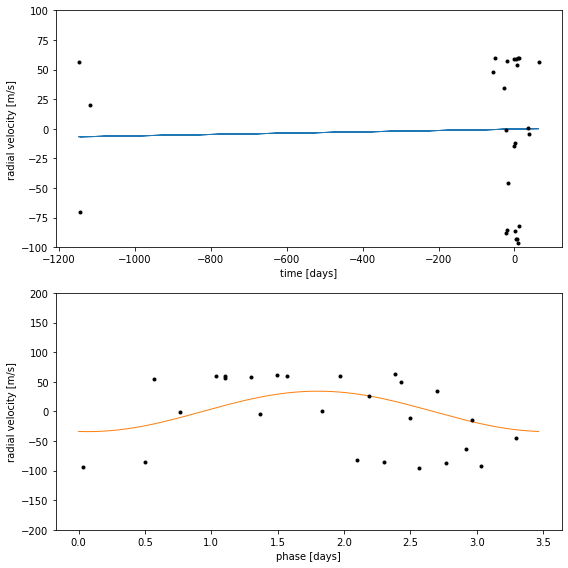

In [987]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.plot(t, map_params["bkg"], color="C0", lw=1)
ax.set_ylim(-100, 100)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.plot(phase * period, map_params["rvphase"], color="C1", lw=1)
ax.set_ylim(-200, 200)
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

plt.tight_layout()

In [996]:
with model:
    paramtrace = pmx.sample(
        draws=1000,
        tune=5000,
        start=map_params,
        chains=6,
        cores=6,
        target_accept=0.95,
        initial_accept=0.5,
        return_inferencedata=True,
    )

Multiprocess sampling (6 chains in 6 jobs)
INFO:pymc3:Multiprocess sampling (6 chains in 6 jobs)
NUTS: [log_sigma_rv, rvtrend, rv0, hk, phi, logP, logK]
INFO:pymc3:NUTS: [log_sigma_rv, rvtrend, rv0, hk, phi, logP, logK]


Sampling 6 chains for 10_000 tune and 2_000 draw iterations (60_000 + 12_000 draws total) took 2053 seconds.
INFO:pymc3:Sampling 6 chains for 10_000 tune and 2_000 draw iterations (60_000 + 12_000 draws total) took 2053 seconds.
The acceptance probability does not match the target. It is 0.9795075562583965, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9951642650518499, but should be close to 0.999. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9872452684101479, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERRO

In [997]:
az.summary(
    paramtrace,
    var_names=["logK", "logP", "phi", "e", "w", "rv0", "rvtrend"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logK,4.120,0.754,2.051,4.587,0.299,0.224,12.0,11.0,1.42
logP,1.200,0.269,1.121,1.971,0.091,0.071,9.0,16.0,2.41
phi,3.881,0.377,3.586,4.958,0.134,0.100,19.0,16.0,1.34
e,0.162,0.233,0.000,0.788,0.090,0.067,12.0,11.0,1.44
w,-0.702,1.948,-3.141,2.875,0.164,0.318,318.0,316.0,1.15
rv0,-8.433,4.412,-15.110,1.174,1.329,0.965,12.0,14.0,1.44
rvtrend,-1.256,6.476,-12.191,10.878,1.093,0.779,34.0,119.0,1.11


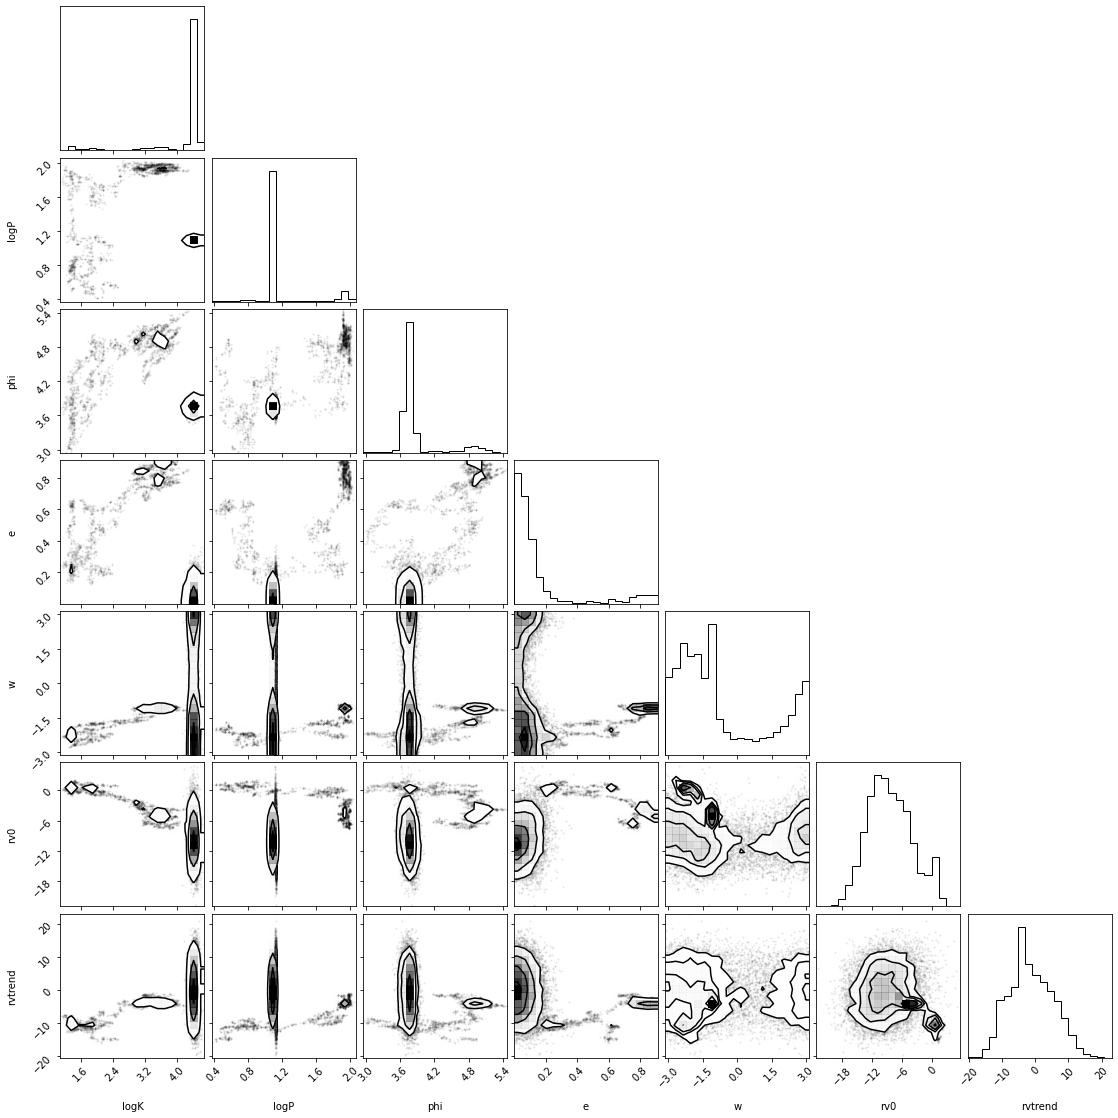

In [998]:
_ = corner(paramtrace, var_names=["logK", "logP", "phi", "e", "w", "rv0", "rvtrend"])

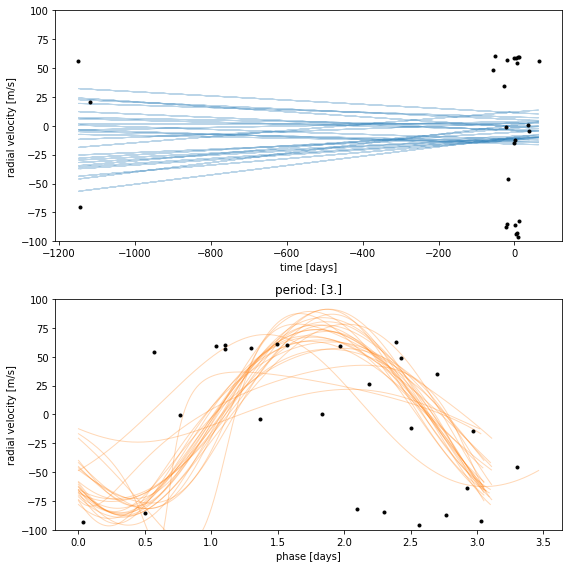

In [994]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

period = map_params["P"]

ax = axes[0]
ax.errorbar(t, rv, yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("time [days]")

ax = axes[1]
ax.errorbar(t % period, rv - map_params["bkg"], yerr=rv_err, fmt=".k")
ax.set_ylabel("radial velocity [m/s]")
ax.set_xlabel("phase [days]")

bkg = paramtrace.posterior["bkg"].values
rvphase = paramtrace.posterior["rvphase"].values
mcmc_per = paramtrace.posterior['logP'].values

for ind in np.random.randint(np.prod(bkg.shape[:2]), size=25):
    i = np.unravel_index(ind, bkg.shape[:2])
    axes[0].plot(t, bkg[i], color="C0", lw=1, alpha=0.3)
    axes[1].plot(phase * np.exp(mcmc_per[i]), rvphase[i], color="C1", lw=1, alpha=0.3)
#     axes[1].plot(phase * period, rvphase[i], color="C5",ls='--', lw=1, alpha=0.3)
    
axes[0].set_ylim(-100, 100)
axes[1].set_ylim(-100, 100)
axes[1].set_title(f'period: {np.round(period.flatten())}')
plt.tight_layout()